Episode 0 finished after 28 steps
Episode 100 finished after 12 steps
Episode 200 finished after 15 steps
Episode 300 finished after 13 steps
Episode 400 finished after 9 steps
Episode 500 finished after 11 steps
Episode 600 finished after 16 steps
Episode 700 finished after 14 steps
Episode 800 finished after 18 steps
Episode 900 finished after 11 steps


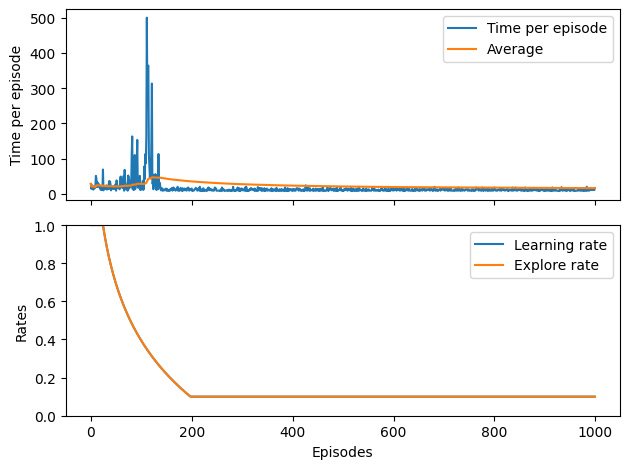

In [1]:
import gymnasium as gym
import numpy as np
import random
import math
import matplotlib.pyplot as plt

# Environment
env = gym.make('CartPole-v1')

# Buckets for discretization
no_buckets = (1, 1, 6, 3)
no_actions = env.action_space.n

state_value_bounds = list(zip(env.observation_space.low, env.observation_space.high))
state_value_bounds[1] = (-0.5, 0.5)
state_value_bounds[3] = (-math.radians(50), math.radians(50))

# Q-table
q_value_table = np.zeros(no_buckets + (no_actions,))

# Parameters
min_explore_rate = 0.1
min_learning_rate = 0.1
max_episodes = 1000
max_time_steps = 250
streak_to_end = 120
solved_time = 199
discount = 0.99
no_streaks = 0


def select_action(state_value, explore_rate):
    if random.random() < explore_rate:
        return env.action_space.sample()
    else:
        return np.argmax(q_value_table[state_value])


def select_explore_rate(x):
    return max(min_explore_rate, min(1.0, 1.0 - math.log10((x + 1) / 25)))


def select_learning_rate(x):
    return max(min_learning_rate, min(1.0, 1.0 - math.log10((x + 1) / 25)))


def bucketize_state_value(state_value):
    bucket_indices = []
    for i in range(len(state_value)):
        if state_value[i] <= state_value_bounds[i][0]:
            bucket_index = 0
        elif state_value[i] >= state_value_bounds[i][1]:
            bucket_index = no_buckets[i] - 1
        else:
            bound_width = state_value_bounds[i][1] - state_value_bounds[i][0]
            offset = (no_buckets[i] - 1) * state_value_bounds[i][0] / bound_width
            scaling = (no_buckets[i] - 1) / bound_width
            bucket_index = int(round(scaling * state_value[i] - offset))
        bucket_indices.append(bucket_index)
    return tuple(bucket_indices)


# Main training loop
if __name__ == "__main__":
    _DEBUG = False
    reward_per_episode = []
    time_per_episode = []
    avgtime_per_episode = []
    learning_rate_per_episode = []
    explore_rate_per_episode = []

    totaltime = 0
    for episode_no in range(max_episodes):
        explore_rate = select_explore_rate(episode_no)
        learning_rate = select_learning_rate(episode_no)
        learning_rate_per_episode.append(learning_rate)
        explore_rate_per_episode.append(explore_rate)

        # Gymnasium reset returns (obs, info)
        observation, _ = env.reset()
        previous_state_value = bucketize_state_value(observation)

        done = False
        time_step = 0

        while not done:
            action = select_action(previous_state_value, explore_rate)

            # Gymnasium step returns 5 values
            observation, reward_gain, terminated, truncated, _ = env.step(action)
            done = terminated or truncated

            state_value = bucketize_state_value(observation)
            best_q_value = np.max(q_value_table[state_value])

            q_value_table[previous_state_value][action] += learning_rate * (
                reward_gain + discount * best_q_value - q_value_table[previous_state_value][action]
            )

            previous_state_value = state_value
            time_step += 1

        # Check solved condition
        if time_step >= solved_time:
            no_streaks += 1
        else:
            no_streaks = 0

        if no_streaks > streak_to_end:
            print(f"CartPole solved after {episode_no} episodes.")
            break

        if episode_no % 100 == 0:
            print(f"Episode {episode_no} finished after {time_step} steps")

        time_per_episode.append(time_step)
        totaltime += time_step
        avgtime_per_episode.append(totaltime / (episode_no + 1))

    env.close()

    # Plotting
    fig, axes = plt.subplots(2, 1, sharex=True)
    axes[0].plot(time_per_episode, label="Time per episode")
    axes[0].plot(avgtime_per_episode, label="Average")
    axes[0].legend()
    axes[0].set_ylabel("Time per episode")

    axes[1].plot(learning_rate_per_episode, label="Learning rate")
    axes[1].plot(explore_rate_per_episode, label="Explore rate")
    axes[1].set_ylim([0, 1])
    axes[1].legend()
    axes[1].set_xlabel("Episodes")
    axes[1].set_ylabel("Rates")

    plt.tight_layout()
    plt.savefig("cp_qlearn_plot.png")
    plt.show()
